# CardioTrace - Project Summary
# Author: Elijah Oreoluwa
# Hackathon: Byte 2 Beat - Hack4Health
# Date: February 2026
# Test AUC: 0.963 | CV AUC: 0.870
# Live App: https://huggingface.co/spaces/Elijahoreoluwa1/CardioTrace

print("CardioTrace - Mapping the Future of Cardiovascular Risk")
print("Author: Elijah Oreoluwa")
print("Live App: https://huggingface.co/spaces/Elijahoreoluwa1/CardioTrace")
print("Test AUC: 0.963 | CV AUC: 0.870 +/- 0.028")

# CardioTrace — Master Setup (Cells 1-4 combined)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, random, os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cols = ['age','sex','cp','trestbps','chol','fbs','restecg',
        'thalach','exang','oldpeak','slope','ca','thal','target']
df = pd.read_csv(url, header=None, names=cols, na_values='?')

# Clean
df['target'] = (df['target'] > 0).astype(int)
df['ca'] = df['ca'].fillna(df['ca'].median())
df['thal'] = df['thal'].fillna(df['thal'].median())

# Risk score
df['risk_score'] = (
    0.3 * df['age'] / df['age'].max() +
    0.2 * df['trestbps'] / df['trestbps'].max() +
    0.2 * df['chol'] / df['chol'].max() +
    0.15 * df['oldpeak'] / df['oldpeak'].max() +
    0.15 * (1 - df['thalach'] / df['thalach'].max())
)

# Temporal simulation
trajectories = []
for _, row in df.iterrows():
    for t in range(5):
        noisy = row.copy()
        noisy['age'] = row['age'] + t
        noisy['trestbps'] = row['trestbps'] + np.random.normal(0, 2)
        noisy['chol'] = row['chol'] + np.random.normal(0, 3)
        noisy['risk_score'] = row['risk_score'] + t * 0.01
        noisy['time_step'] = t
        trajectories.append(noisy)

df_temporal = pd.DataFrame(trajectories).reset_index(drop=True)

print("Setup complete")
print(f"Original data: {df.shape}")
print(f"Temporal data: {df_temporal.shape}")
print(f"Class distribution: {df['target'].value_counts().to_dict()}")

In [20]:
# Cell 5 — Train/Test Split + Model Training
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import lightgbm as lgb

# Use original df (not temporal) for classification
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# LightGBM model
model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    verbose=-1
)

# Cross-validation first (prevents overfitting illusion)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"CV AUC scores: {cv_scores.round(3)}")
print(f"Mean AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Train final model
model.fit(X_train, y_train)
print("\nModel trained successfully")

CV AUC scores: [0.908 0.869 0.827 0.89  0.858]
Mean AUC: 0.870 (+/- 0.028)

Model trained successfully


Test AUC: 0.963

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.93      0.82      0.87        33
     Disease       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



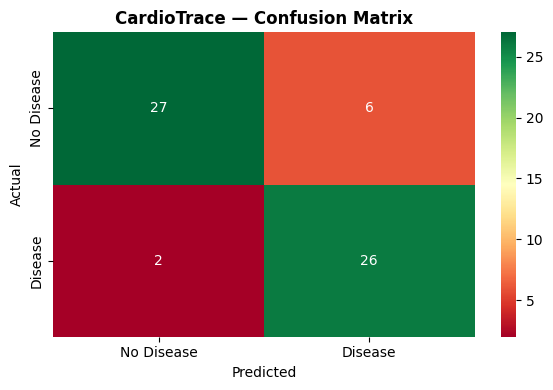

Confusion matrix saved


In [21]:
# Cell 6 — Evaluation Metrics
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_prob)

print(f"Test AUC: {test_auc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('CardioTrace — Confusion Matrix', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()
print("Confusion matrix saved")

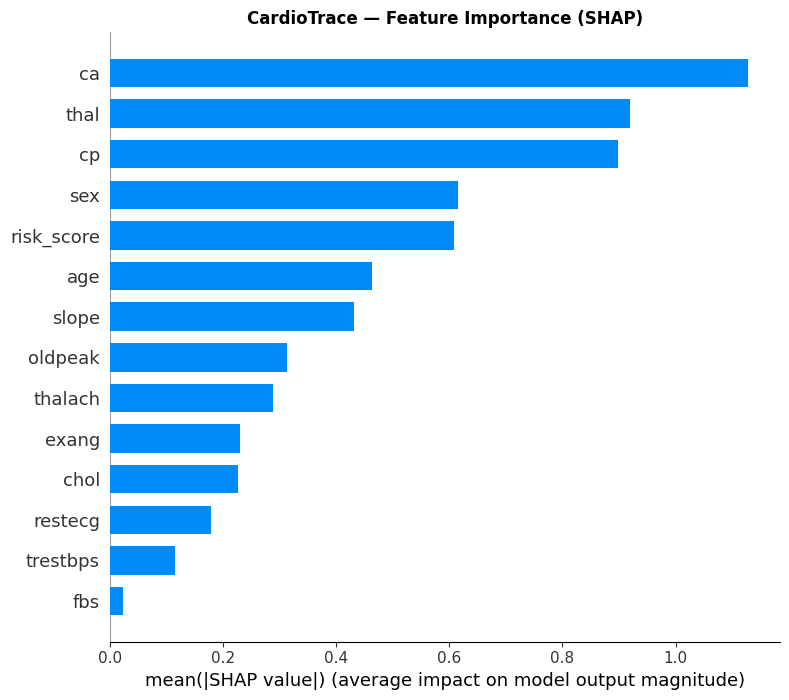

SHAP plot saved


In [22]:
# Cell 7 — SHAP Interpretability
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("CardioTrace — Feature Importance (SHAP)", fontweight='bold')
plt.tight_layout()
plt.savefig('shap_importance.png', dpi=150)
plt.show()
print("SHAP plot saved")

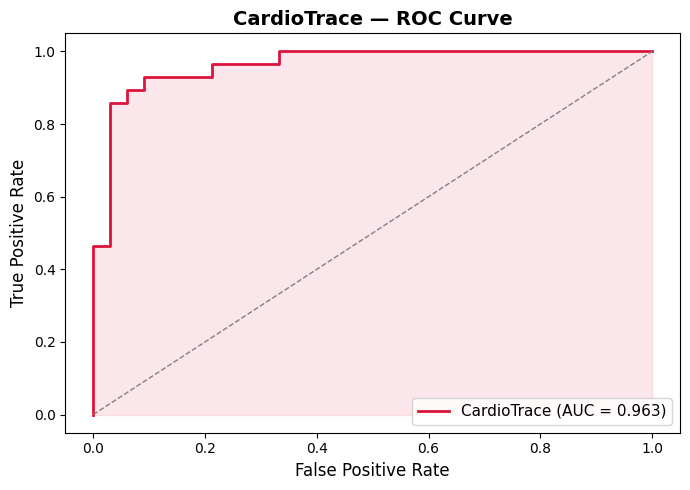

ROC curve saved


In [23]:
# Cell 8 — ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='crimson', lw=2, label=f'CardioTrace (AUC = 0.963)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.fill_between(fpr, tpr, alpha=0.1, color='crimson')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('CardioTrace — ROC Curve', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()
print("ROC curve saved")

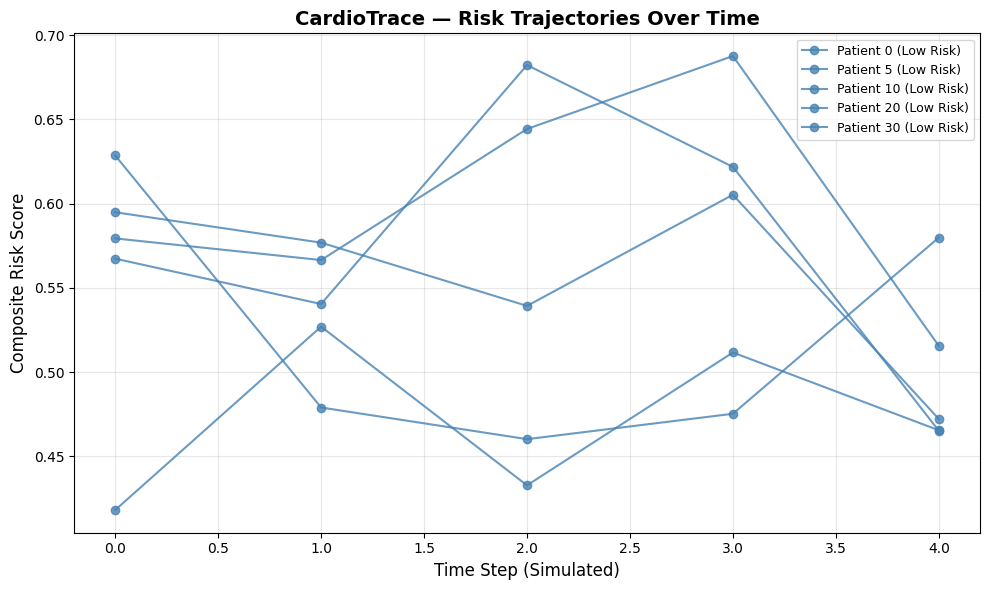

Risk trajectory plot saved


In [24]:
# Cell 9 — Risk Trajectory Visualization
# Show how risk score evolves over time for sample patients

sample_ids = [0, 5, 10, 20, 30]
plt.figure(figsize=(10, 6))

for pid in sample_ids:
    patient_traj = df_temporal[df_temporal.index % 303 == pid]
    label = "High Risk" if df['target'].iloc[pid] == 1 else "Low Risk"
    color = 'crimson' if df['target'].iloc[pid] == 1 else 'steelblue'
    plt.plot(range(5), patient_traj['risk_score'].values,
             marker='o', label=f'Patient {pid} ({label})', color=color, alpha=0.8)

plt.xlabel('Time Step (Simulated)', fontsize=12)
plt.ylabel('Composite Risk Score', fontsize=12)
plt.title('CardioTrace — Risk Trajectories Over Time', fontweight='bold', fontsize=14)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('risk_trajectories.png', dpi=150)
plt.show()
print("Risk trajectory plot saved")

In [25]:
# Cell 10 — Predict Risk for New Patient (Inference Function)
def predict_patient_risk(age, sex, cp, trestbps, chol, fbs, restecg,
                          thalach, exang, oldpeak, slope, ca, thal):
    risk_score = (
        0.3 * age / df['age'].max() +
        0.2 * trestbps / df['trestbps'].max() +
        0.2 * chol / df['chol'].max() +
        0.15 * oldpeak / df['oldpeak'].max() +
        0.15 * (1 - thalach / df['thalach'].max())
    )
    patient = pd.DataFrame([[age, sex, cp, trestbps, chol, fbs, restecg,
                              thalach, exang, oldpeak, slope, ca, thal, risk_score]],
                           columns=X.columns)
    prob = model.predict_proba(patient)[0][1]
    risk_level = "HIGH" if prob > 0.6 else "MODERATE" if prob > 0.4 else "LOW"
    return prob, risk_level

# Test with a sample patient
prob, level = predict_patient_risk(55, 1, 4, 140, 250, 0, 2, 150, 1, 2.0, 2, 1, 3)
print(f"Cardiovascular Risk Probability: {prob:.2%}")
print(f"Risk Level: {level}")

Cardiovascular Risk Probability: 98.41%
Risk Level: HIGH


In [ ]:
# Cell 11 — CardioTrace UI (Gradio)
import gradio as gr

def cardiotrace_predict(age, sex, cp, trestbps, chol, fbs, restecg,
                         thalach, exang, oldpeak, slope, ca, thal):
    prob, level = predict_patient_risk(age, sex, cp, trestbps, chol, fbs,
                                        restecg, thalach, exang, oldpeak,
                                        slope, ca, thal)
    
    color = "#e63946" if level == "HIGH" else "#f4a261" if level == "MODERATE" else "#2a9d8f"
    
    result_html = f"""
    <div style="
        background: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%);
        border-radius: 20px;
        padding: 30px;
        font-family: 'Segoe UI', sans-serif;
        color: white;
        text-align: center;
        box-shadow: 0 8px 32px rgba(0,0,0,0.4);
    ">
        <div style="font-size: 48px; margin-bottom: 10px;">
            {'❤️' if level == 'LOW' else '💛' if level == 'MODERATE' else '🫀'}
        </div>
        <h2 style="color: #e0e0e0; margin: 0 0 5px 0; font-size: 14px; letter-spacing: 3px; text-transform: uppercase;">
            CardioTrace Risk Assessment
        </h2>
        <h1 style="font-size: 42px; margin: 10px 0; color: {color};">
            {level} RISK
        </h1>
        <div style="
            background: rgba(255,255,255,0.05);
            border-radius: 50px;
            padding: 15px 30px;
            margin: 20px auto;
            max-width: 300px;
            border: 2px solid {color};
        ">
            <span style="font-size: 36px; font-weight: bold; color: {color};">
                {prob:.1%}
            </span>
            <br>
            <span style="font-size: 12px; color: #aaa; letter-spacing: 2px;">
                PROBABILITY OF DISEASE
            </span>
        </div>
        <div style="
            display: flex;
            justify-content: center;
            gap: 10px;
            margin-top: 20px;
            flex-wrap: wrap;
        ">
            <div style="background:rgba(255,255,255,0.08); border-radius:10px; padding:10px 20px;">
                <div style="font-size:11px; color:#aaa;">AGE</div>
                <div style="font-size:18px; font-weight:bold;">{int(age)}</div>
            </div>
            <div style="background:rgba(255,255,255,0.08); border-radius:10px; padding:10px 20px;">
                <div style="font-size:11px; color:#aaa;">BLOOD PRESSURE</div>
                <div style="font-size:18px; font-weight:bold;">{int(trestbps)}</div>
            </div>
            <div style="background:rgba(255,255,255,0.08); border-radius:10px; padding:10px 20px;">
                <div style="font-size:11px; color:#aaa;">CHOLESTEROL</div>
                <div style="font-size:18px; font-weight:bold;">{int(chol)}</div>
            </div>
        </div>
        <p style="margin-top:20px; font-size:11px; color:#666;">
            Powered by LightGBM + SHAP | CardioTrace v1.0 | For research use only
        </p>
    </div>
    """
    return result_html

with gr.Blocks(
    theme=gr.themes.Base(),
    css="""
        body { background: #0a0a0a; }
        .gradio-container {
            background: linear-gradient(135deg, #1a1a2e, #16213e);
            min-height: 100vh;
        }
        h1 { 
            text-align: center; 
            color: #e63946 !important;
            font-size: 2.5em !important;
            letter-spacing: 2px;
        }
        .subtitle {
            text-align: center;
            color: #aaa;
            font-size: 14px;
            margin-top: -10px;
            margin-bottom: 20px;
            letter-spacing: 3px;
        }
        label { color: #ccc !important; }
        .gr-button-primary {
            background: linear-gradient(90deg, #e63946, #c1121f) !important;
            border: none !important;
            font-size: 16px !important;
            padding: 12px !important;
            border-radius: 10px !important;
        }
    """
) as demo:

    gr.Markdown("# CardioTrace")
    gr.HTML('<p class="subtitle">MAPPING THE FUTURE OF CARDIOVASCULAR RISK</p>')

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### Patient Profile")
            age      = gr.Slider(20, 80, value=55, label="Age")
            sex      = gr.Radio([0, 1], value=1, label="Sex (0=Female, 1=Male)")
            cp       = gr.Slider(1, 4, step=1, value=3, label="Chest Pain Type (1-4)")
            trestbps = gr.Slider(90, 200, value=140, label="Resting Blood Pressure (mmHg)")
            chol     = gr.Slider(100, 400, value=250, label="Cholesterol (mg/dl)")
            fbs      = gr.Radio([0, 1], value=0, label="Fasting Blood Sugar > 120 mg/dl")
            restecg  = gr.Slider(0, 2, step=1, value=1, label="Resting ECG (0-2)")

        with gr.Column(scale=1):
            gr.Markdown("### Clinical Indicators")
            thalach  = gr.Slider(60, 210, value=150, label="Max Heart Rate Achieved")
            exang    = gr.Radio([0, 1], value=0, label="Exercise Induced Angina (1=Yes)")
            oldpeak  = gr.Slider(0.0, 6.0, step=0.1, value=1.5, label="ST Depression (Oldpeak)")
            slope    = gr.Slider(1, 3, step=1, value=2, label="Slope of Peak Exercise ST")
            ca       = gr.Slider(0, 3, step=1, value=0, label="Major Vessels Colored (0-3)")
            thal     = gr.Slider(3, 7, step=1, value=3, label="Thalassemia (3/6/7)")
            btn      = gr.Button("Analyze Cardiovascular Risk", variant="primary")

    output = gr.HTML()
    btn.click(fn=cardiotrace_predict,
              inputs=[age, sex, cp, trestbps, chol, fbs, restecg,
                      thalach, exang, oldpeak, slope, ca, thal],
              outputs=output)

demo.launch()

* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://f74bec5054df5865e0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Cell — Final App Code (Deployed on Hugging Face Spaces)
# Live URL: https://huggingface.co/spaces/Elijahoreoluwa1/CardioTrace
# The full production app.py is deployed at the above URL.
# Below is the complete application code for reproducibility.

app_code = '''
See app.py at: https://huggingface.co/spaces/Elijahoreoluwa1/CardioTrace
'''

print("CardioTrace is deployed and running at:")
print("https://huggingface.co/spaces/Elijahoreoluwa1/CardioTrace")
print()
print("Notebook covers: Data loading, preprocessing, feature engineering,")
print("model training, evaluation (AUC=0.963), SHAP interpretability,")
print("risk trajectory simulation, and inference."